In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import prince

import gower

import plotly.express as px
from ipywidgets import interact

%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<IPython.core.display.Javascript object>

In [3]:
loans = pd.read_csv("data/SBA_clnd.csv")
loans.head()

,Name,City,State,Zip,Bank,BankState,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
0,CARVEL,APEX,NC,27502,STEARNS BK NATL ASSOC,MN,2006,2,1,0,0,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,2006,0.866025,5.000000e-01,1.0,0.75,1.0,0.5,0.866025
1,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,2006,7,0,0,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,2006,1.000000,6.123234e-17,1.0,0.85,0.0,0.5,0.866025
2,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,2006,18,1,5,23,1.0,0.0,438541.0,0,61,0.0,0,6.916667,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
3,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,2006,4,0,0,4,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
4,"RZI, INC.",NEW ORLEANS,LA,70130,BUSINESS RES. CAP. SPECIALTY B,LA,2006,3,0,0,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,2006,0.866025,-5.000000e-01,1.0,0.85,0.0,0.5,0.866025


<IPython.core.display.Javascript object>

In [4]:
bank_counts = loans["Bank"].value_counts()
loans["bank_size"] = loans["Bank"].apply(lambda x: bank_counts[x])

<IPython.core.display.Javascript object>

In [5]:
default = loans[loans["MIS_Status"] == 1]
default = default[default["NoEmp"] <= 100]


<IPython.core.display.Javascript object>

[Justification for Employee Cutoff](https://en.wikipedia.org/wiki/Small_business#:~:text=The%20U.S.%20Small%20Business%20Administration,are%20widely%20considered%20small%20businesses)

In [6]:
drop_cols = [
    "Name",
    "City",
    "Zip",
    "Bank",
    "ApprovalFY",
    "sba_pre_approv",
    "Disbr_Month_sin",
    "Disbr_Month_cos",
    "Appv_Month_sin",
    "Appv_Month_cos",
    "MIS_Status",
    "twoDigNAICS",
]
default = default.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

In [7]:
num_cols = [
    "NoEmp",
    "CreateJob",
    "RetainedJob",
    "DisbursementGross",
    "Term_years",
    "Disbr_year",
    "percent_SBA",
    "bank_size",
]
cat_cols = [
    "State",
    "BankState",
    "NewExist",
    "RevLineCr",
    "LowDoc",
    "is_franchise",
    "bank_out_of_state",
    "UrbanRural_cleaned",
]

# will want cat_cols as str for discrete coloring in graphs
# converting here breaks famd
# loans[cat_cols] = loans[cat_cols].astype("str")
is_cat = default.columns.isin(cat_cols)

<IPython.core.display.Javascript object>

In [8]:
default.head()

,State,BankState,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,is_franchise,bank_out_of_state,Term_years,UrbanRural_cleaned,Disbr_year,percent_SBA,bank_size
8,ME,SD,9,0,0,9,0.0,0.0,1350000.0,0.0,0,13.916667,0.0,2006,0.75,24752
11,TX,SD,4,1,1,5,1.0,0.0,60859.0,0.0,0,2.166667,1.0,2006,0.50,24752
15,WA,OH,1,1,3,4,0.0,0.0,28090.0,0.0,0,0.416667,0.0,2006,0.85,20370
16,CO,IL,4,0,8,4,1.0,0.0,76432.0,0.0,0,4.500000,1.0,2006,0.50,34974
24,NV,SD,10,0,11,10,1.0,0.0,90518.0,0.0,0,2.250000,0.0,2006,0.50,24752


<IPython.core.display.Javascript object>

In [9]:
sample = default.sample(1000)
sample.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 380192 to 168534
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               1000 non-null   object 
 1   BankState           1000 non-null   object 
 2   NoEmp               1000 non-null   int64  
 3   NewExist            1000 non-null   int64  
 4   CreateJob           1000 non-null   int64  
 5   RetainedJob         1000 non-null   int64  
 6   RevLineCr           1000 non-null   float64
 7   LowDoc              1000 non-null   float64
 8   DisbursementGross   1000 non-null   float64
 9   is_franchise        1000 non-null   float64
 10  bank_out_of_state   1000 non-null   int64  
 11  Term_years          1000 non-null   float64
 12  UrbanRural_cleaned  1000 non-null   float64
 13  Disbr_year          1000 non-null   int64  
 14  percent_SBA         1000 non-null   float64
 15  bank_size           1000 non-null   int64  
dtyp

<IPython.core.display.Javascript object>

### Calculate Gower Distance Matrix for Mixed Data

In [10]:
gower_dist = gower.gower_matrix(sample, cat_features=is_cat)
gower_df = pd.DataFrame(gower_dist, columns=sample.index, index=sample.index)

<IPython.core.display.Javascript object>

In [11]:
scaler = StandardScaler()
X_std = scaler.fit_transform(sample[num_cols])
X_std = pd.DataFrame(X_std, columns=num_cols, index=sample[num_cols].index)
# pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols)

scaled_X = pd.concat((X_std, sample[cat_cols]), axis=1)

# for after cluster, doing some preliminary visualization
# scaled_X["label"] = labels
scaled_X

,NoEmp,CreateJob,RetainedJob,DisbursementGross,Term_years,Disbr_year,percent_SBA,bank_size,State,BankState,NewExist,RevLineCr,LowDoc,is_franchise,bank_out_of_state,UrbanRural_cleaned
380192,0.617369,-0.387115,0.493122,-0.429909,-0.709726,-1.388310,-0.698776,0.389370,PA,RI,0,1.0,0.0,0.0,0,0.0
34431,2.491023,-0.387115,1.844670,1.039746,-0.298916,-0.362970,-0.698776,1.938519,FL,NC,0,1.0,0.0,0.0,0,0.0
96007,-0.051793,5.820637,2.423905,1.498310,-0.658375,0.149700,-0.698776,-0.079624,WA,OH,0,1.0,0.0,0.0,0,0.0
448418,-0.587123,-0.387115,-0.375730,-0.542093,0.034868,-0.875640,-0.698776,-0.923269,UT,UT,0,1.0,0.0,0.0,1,0.0
86482,-0.185626,-0.387115,-0.086113,-0.373814,-0.375943,0.149700,-0.698776,1.938519,GA,NC,0,1.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329392,0.483537,-0.387115,-0.472270,4.983237,4.297024,-1.900980,0.909695,-1.018123,GA,GA,0,0.0,0.0,0.0,1,0.0
456432,-0.587123,-0.387115,-0.472270,0.164696,3.886213,-0.875640,1.553083,-1.012804,WI,WI,0,0.0,0.0,0.0,1,1.0
138797,-0.453290,-0.387115,-0.279191,-0.486004,-1.043509,1.175039,-0.698776,-0.755345,OH,OH,0,0.0,0.0,0.0,1,1.0
78229,1.286531,0.109505,0.975818,0.353455,-0.350267,0.149700,-0.698776,0.595772,AZ,IL,0,1.0,0.0,0.0,0,0.0


<IPython.core.display.Javascript object>

In [12]:
scaled_X.describe()

,NoEmp,CreateJob,RetainedJob,DisbursementGross,Term_years,Disbr_year,percent_SBA,bank_size,NewExist,RevLineCr,LowDoc,is_franchise,bank_out_of_state,UrbanRural_cleaned
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.329071e-17,1.421085e-17,-3.552714e-17,-1.421085e-17,1.936229e-16,-4.291500e-14,-2.202682e-16,5.151435e-17,0.266000,0.422000,0.039000,0.036000,0.269000,0.165000
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.442085,0.494126,0.193692,0.186383,0.443662,0.371366
min,-7.209554e-01,-3.871155e-01,-4.722696e-01,-5.990795e-01,-1.351617e+00,-2.413649e+00,-1.290693e+00,-1.021638e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.532905e-01,-3.871155e-01,-3.757304e-01,-4.860037e-01,-5.813478e-01,-3.629702e-01,-6.987760e-01,-8.427989e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.194580e-01,-3.871155e-01,-2.791912e-01,-3.325228e-01,-9.351068e-02,1.496996e-01,-6.987760e-01,-1.314216e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.203929e-02,1.095048e-01,1.042623e-02,1.154013e-02,3.429752e-01,6.623694e-01,9.096946e-01,5.957723e-01,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.266229e+01,1.550473e+01,2.404868e+01,1.059271e+01,6.351075e+00,3.225718e+00,2.518165e+00,1.938519e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

In [13]:
famd = prince.FAMD(n_components=2)
famd.fit(scaled_X)

FAMD(check_input=True, copy=True, engine='auto', n_components=2, n_iter=3,
     random_state=None)

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


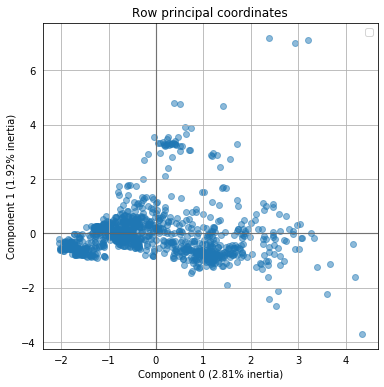

<IPython.core.display.Javascript object>

In [14]:
famd.plot_row_coordinates(
    scaled_X, alpha=0.5, ellipse_fill=False,
)
plt.show()

In [15]:
# store the famd coordinates to do custom plotting
sample["famd_x"] = famd.row_coordinates(scaled_X).iloc[:, 0]
sample["famd_y"] = famd.row_coordinates(scaled_X).iloc[:, 1]

<IPython.core.display.Javascript object>

Just from the Factor Analysis, it appears there are at least two dense clusters, with some outliers. DBSCAN should perform excellently here.

In [16]:
# will want cat_cols as str for discrete coloring in graphs
sample[cat_cols] = sample[cat_cols].astype("str")

<IPython.core.display.Javascript object>

### K-Medoids

In [17]:
k = 4
nrows = gower_df.shape[0]
init_medoids = np.random.randint(0, nrows, k)
init_medoids

array([ 55, 212, 980, 848])

<IPython.core.display.Javascript object>

In [18]:
kmed = kmedoids(
    gower_dist, initial_index_medoids=init_medoids, data_type="distance_matrix"
)

kmed.process()

<IPython.core.display.Javascript object>

In [19]:
labels = kmed.predict(gower_dist)
sample_kmeds = sample.copy()
sample_kmeds["label"] = labels
sample_kmeds["label"] = sample_kmeds["label"].astype("str")
sample_kmeds["label"].value_counts(normalize=True)

1    0.380
0    0.290
2    0.218
3    0.112
Name: label, dtype: float64

<IPython.core.display.Javascript object>

In [20]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample_kmeds[num_cols_labels].groupby("label").median().T
clst_avg.style.background_gradient(axis=1)

label,0,1,2,3
NoEmp,3.000000,2.000000,3.000000,3.500000
CreateJob,0.000000,0.000000,0.000000,0.000000
RetainedJob,3.000000,2.000000,3.000000,3.000000
DisbursementGross,63518.500000,60043.000000,49412.000000,54385.000000
Term_years,3.416667,5.208333,3.500000,3.791667
Disbr_year,2006.000000,2006.000000,2006.000000,2006.000000
percent_SBA,0.500000,0.850000,0.500000,0.500000
bank_size,34974.000000,4042.000000,21344.000000,20370.000000


<IPython.core.display.Javascript object>

In [21]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample_kmeds[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,0,1,2,3
State,FL,CA,FL,CA
BankState,NC,CA,VA,NC
NewExist,0,1,0,0
RevLineCr,1.0,0.0,0.0,1.0
LowDoc,0.0,0.0,0.0,0.0
is_franchise,0.0,0.0,0.0,0.0
bank_out_of_state,0,1,0,0
UrbanRural_cleaned,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [22]:
@interact
def plot(color=sample_kmeds.columns, opacity=(0, 1.0)):
    fig = px.scatter(
        data_frame=sample_kmeds,
        x="famd_x",
        y="famd_y",
        color=color,
        hover_data=["DisbursementGross", "LowDoc", "label"],
        # symbol="label",
    )
    fig.update_traces(marker={"opacity": opacity})
    fig.show()

interactive(children=(Dropdown(description='color', options=('State', 'BankState', 'NoEmp', 'NewExist', 'Creat…

<IPython.core.display.Javascript object>

### DBSCAN

In [23]:
clst = DBSCAN(eps=0.1, min_samples=10, metric="precomputed")
clst.fit(gower_df)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

In [24]:
sample_dbscan = sample.copy()
sample_dbscan["label"] = clst.labels_
sample_dbscan["label"] = sample_dbscan["label"].astype("str")
sample_dbscan["label"].value_counts()

0     618
-1    275
2      63
1      29
3      15
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [25]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample_dbscan[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,-1,0,1,2,3
NoEmp,6.589091,5.019417,3.689655,4.857143,4.000000
CreateJob,2.523636,1.135922,1.724138,1.174603,2.600000
RetainedJob,4.090909,5.048544,3.172414,7.873016,3.933333
DisbursementGross,177044.647273,77006.092233,67185.724138,191742.857143,88967.666667
Term_years,5.338182,3.873382,3.876437,6.062169,2.050000
Disbr_year,2005.320000,2005.791262,2007.206897,2005.936508,2005.533333
percent_SBA,0.677123,0.568447,0.551724,0.746032,0.540000
bank_size,7378.996364,31311.064725,3695.310345,8799.571429,3380.600000


<IPython.core.display.Javascript object>

In [26]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample_dbscan[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,-1,0,1,2,3
State,TX,['CA' 'FL'],UT,CA,NY
BankState,OH,NC,UT,CA,NY
NewExist,0,0,0,0,0
RevLineCr,0.0,1.0,1.0,0.0,0.0
LowDoc,0.0,0.0,0.0,0.0,0.0
is_franchise,0.0,0.0,0.0,0.0,0.0
bank_out_of_state,1,0,1,1,1
UrbanRural_cleaned,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [27]:
# for dbscan, get rid of outliers
sample_dbscan = sample_dbscan[sample_dbscan["label"] != "-1"]


@interact
def plot(color=sample_dbscan.columns, opacity=(0, 1.0)):
    fig = px.scatter(
        data_frame=sample_dbscan,
        x="famd_x",
        y="famd_y",
        color=color,
        hover_data=["DisbursementGross", "LowDoc", "label"],
        # symbol="label",
    )
    fig.update_traces(marker={"opacity": opacity})
    fig.show()

interactive(children=(Dropdown(description='color', options=('State', 'BankState', 'NoEmp', 'NewExist', 'Creat…

<IPython.core.display.Javascript object>

### Hierarchical

In [28]:
clst = AgglomerativeClustering(n_clusters=4, affinity="precomputed", linkage="complete")
clst.fit(gower_df)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=4)

<IPython.core.display.Javascript object>

In [29]:
sample_hier = sample.copy()
sample_hier["label"] = clst.labels_
sample_hier["label"] = sample_hier["label"].astype("str")
sample_hier["label"].value_counts()

1    512
0    332
3     91
2     65
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample_hier[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,0,1,2,3
NoEmp,5.219880,5.402344,6.061538,5.428571
CreateJob,1.557229,1.267578,3.415385,1.879121
RetainedJob,5.009036,5.298828,1.923077,4.296703
DisbursementGross,150000.367470,83299.623047,170945.338462,88777.670330
Term_years,5.727912,3.457194,5.912821,3.634615
Disbr_year,2005.713855,2005.687500,2005.230769,2006.142857
percent_SBA,0.753165,0.506152,0.795385,0.524264
bank_size,10009.030120,35152.662109,2487.061538,6691.076923


<IPython.core.display.Javascript object>

In [31]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample_hier[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,0,1,2,3
State,CA,CA,TX,UT
BankState,CA,NC,CA,UT
NewExist,0,0,1,0
RevLineCr,0.0,1.0,0.0,1.0
LowDoc,0.0,0.0,0.0,0.0
is_franchise,0.0,0.0,0.0,0.0
bank_out_of_state,0,0,1,1
UrbanRural_cleaned,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [32]:
@interact
def plot(color=sample_hier.columns, opacity=(0, 1.0)):
    fig = px.scatter(
        data_frame=sample_hier,
        x="famd_x",
        y="famd_y",
        color=color,
        hover_data=["DisbursementGross", "LowDoc", "label"],
        # symbol="label",
    )
    fig.update_traces(marker={"opacity": opacity})
    fig.show()

interactive(children=(Dropdown(description='color', options=('State', 'BankState', 'NoEmp', 'NewExist', 'Creat…

<IPython.core.display.Javascript object>

### Cluster Analysis Visualization

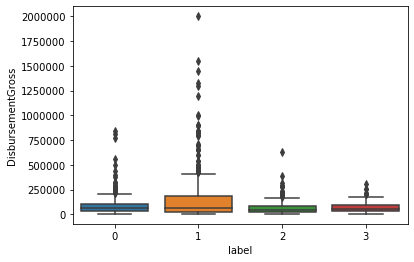

<IPython.core.display.Javascript object>

In [60]:
sns.boxplot(x="label", y="DisbursementGross", data=sample_kmeds)
plt.show()

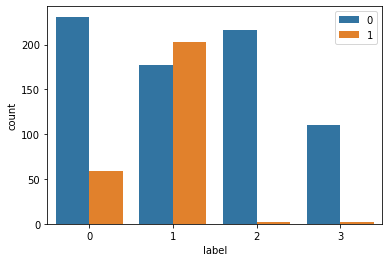

<IPython.core.display.Javascript object>

In [61]:
sns.countplot(x="label", hue="NewExist", data=sample_kmeds)
plt.legend(loc="upper right")
plt.show()

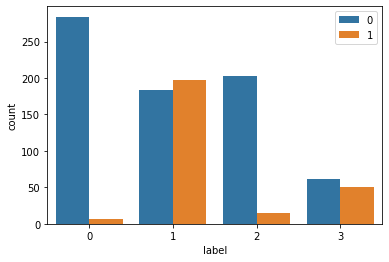

<IPython.core.display.Javascript object>

In [62]:
sns.countplot(x="label", hue="bank_out_of_state", data=sample_kmeds)
plt.legend(loc="upper right")
plt.show()

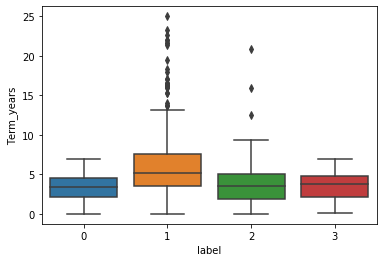

<IPython.core.display.Javascript object>

In [63]:
sns.boxplot(x="label", y="Term_years", data=sample_kmeds)
plt.show()

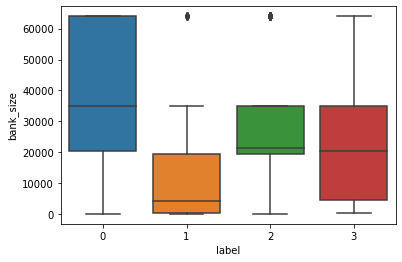

<IPython.core.display.Javascript object>

In [64]:
sns.boxplot(x="label", y="bank_size", data=sample_kmeds)
plt.show()

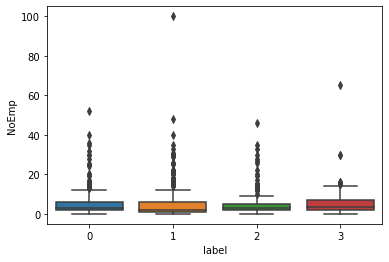

<IPython.core.display.Javascript object>

In [69]:
sns.boxplot(x="label", y="NoEmp", data=sample_kmeds)
plt.show()

Some EDA

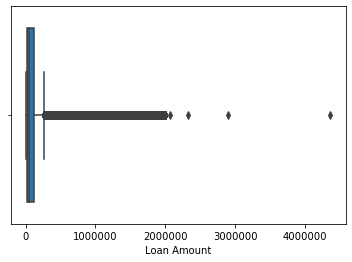

<IPython.core.display.Javascript object>

In [39]:
sns.boxplot(default["DisbursementGross"])
plt.xlabel("Loan Amount")
plt.show()

In [40]:
default["DisbursementGross"].describe()

count    1.263440e+05
mean     1.150325e+05
std      1.966099e+05
min      4.000000e+03
25%      2.500000e+04
50%      5.130800e+04
75%      1.173298e+05
max      4.362157e+06
Name: DisbursementGross, dtype: float64

<IPython.core.display.Javascript object>

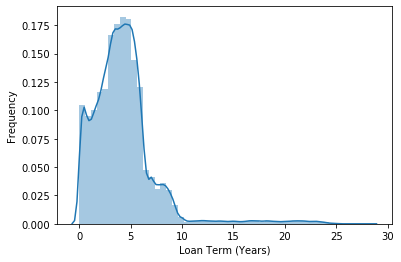

<IPython.core.display.Javascript object>

In [41]:
sns.distplot(default["Term_years"])
plt.xlabel("Loan Term (Years)")
plt.ylabel("Frequency")
plt.show()

In [42]:
default["Term_years"].describe()

count    126344.000000
mean          4.318096
std           3.215651
min           0.000000
25%           2.416667
50%           4.000000
75%           5.416667
max          28.250000
Name: Term_years, dtype: float64

<IPython.core.display.Javascript object>

In [43]:
default["Term_years"].value_counts().sort_index()

0.000000      571
0.083333     1077
0.166667     1197
0.250000     1142
0.333333     1158
0.416667     1175
0.500000     1179
0.583333     1095
0.666667      959
0.750000      978
0.833333      881
0.916667      967
1.000000      950
1.083333      931
1.166667      956
1.250000      932
1.333333      976
1.416667     1044
1.500000     1046
1.583333     1089
1.666667     1131
1.750000     1098
1.833333     1086
1.916667     1159
2.000000     1169
2.083333     1217
2.166667     1240
2.250000     1310
2.333333     1396
2.416667     1344
2.500000     1433
2.583333     1468
2.666667     1438
2.750000     1413
2.833333     1523
2.916667     1549
3.000000     1675
3.083333     1734
3.166667     1766
3.250000     1770
3.333333     1889
3.416667     1827
3.500000     1925
3.583333     1751
3.666667     1812
3.750000     1695
3.833333     1773
3.916667     1799
4.000000     1832
4.083333     1864
4.166667     1874
4.250000     1781
4.333333     1833
4.416667     1904
4.500000     1937
4.583333  

<IPython.core.display.Javascript object>

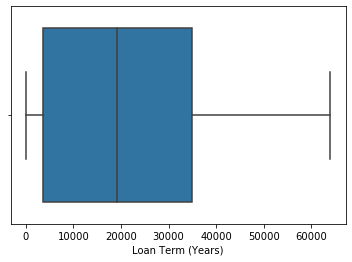

<IPython.core.display.Javascript object>

In [44]:
sns.boxplot(default["bank_size"])
plt.xlabel("Loan Term (Years)")
plt.show()

In [45]:
default["bank_size"].describe()

count    126344.000000
mean      22947.401594
std       21847.558460
min           1.000000
25%        3562.000000
50%       19250.000000
75%       34974.000000
max       64008.000000
Name: bank_size, dtype: float64

<IPython.core.display.Javascript object>

C:\Users\dgump\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



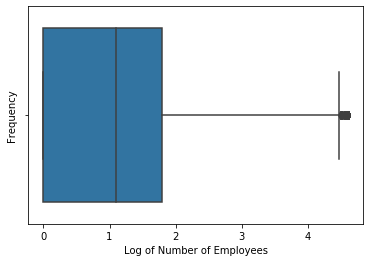

<IPython.core.display.Javascript object>

In [46]:
sns.boxplot(np.log(default["NoEmp"]))
plt.xlabel("Log of Number of Employees")
plt.ylabel("Frequency")
plt.show()

In [47]:
default["NoEmp"].value_counts().sort_index()

0       1536
1      30253
2      24160
3      15488
4      11731
5       9190
6       6377
7       4110
8       3717
9       1847
10      3466
11      1081
12      2106
13       758
14       867
15      1770
16       559
17       411
18       575
19       227
20      1145
21       248
22       333
23       199
24       205
25       712
26       152
27       111
28       147
29        64
30       548
31        63
32       112
33        60
34        71
35       271
36        70
37        34
38        63
39        29
40       260
41        27
42        60
43        26
44        21
45       145
46        25
47        25
48        34
49        15
50       193
51        10
52        22
53         8
54        14
55        52
56        11
57         8
58         9
59         7
60       106
61         5
62         6
63        11
64         8
65        51
66         4
67        10
68        13
70        38
71         3
72         8
73         6
74         8
75        42
76         5
77         4

<IPython.core.display.Javascript object>

In [48]:
default["NoEmp"].describe()

count    126344.000000
mean          5.408599
std           7.929105
min           0.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         100.000000
Name: NoEmp, dtype: float64

<IPython.core.display.Javascript object>

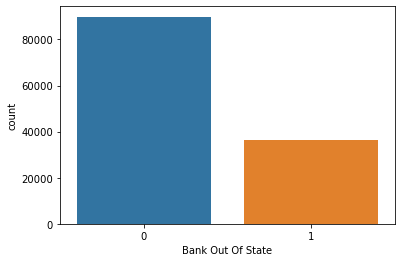

<IPython.core.display.Javascript object>

In [49]:
sns.countplot(x="NewExist", data=default)
plt.xlabel("Bank Out Of State")
plt.show()

In [50]:
default["NewExist"].value_counts(normalize=True)

0    0.711233
1    0.288767
Name: NewExist, dtype: float64

<IPython.core.display.Javascript object>

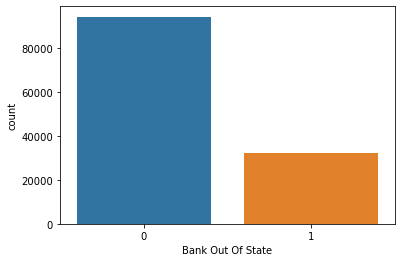

<IPython.core.display.Javascript object>

In [51]:
sns.countplot(x="bank_out_of_state", data=default)
plt.xlabel("Bank Out Of State")
plt.show()

In [52]:
default["bank_out_of_state"].value_counts(normalize=True)

0    0.744673
1    0.255327
Name: bank_out_of_state, dtype: float64

<IPython.core.display.Javascript object>

In [53]:
loans[loans["MIS_Status"] == 1]

,Name,City,State,Zip,Bank,BankState,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
8,NEW DIMENSION HOMES INC,CLINTON (CENSUS NAME FOR CLINT,ME,4927,WELLS FARGO BANK NATL ASSOC,SD,2006,9,0,0,9,0.0,0.0,1350000.0,1,23,0.0,0,13.916667,0.0,2006,0.500000,8.660254e-01,1.0,0.75,24752,0.5,0.866025
11,LILY DAY GARDENS,BURNET,TX,78611,WELLS FARGO BANK NATL ASSOC,SD,2006,4,1,1,5,1.0,0.0,60859.0,1,44,0.0,0,2.166667,1.0,2006,0.500000,8.660254e-01,1.0,0.50,24752,0.5,0.866025
15,URBAN BEAST-SEATTLE LLC,SEATTLE,WA,98109,U.S. BANK NATIONAL ASSOCIATION,OH,2006,1,1,3,4,0.0,0.0,28090.0,1,45,0.0,0,0.416667,0.0,2006,-0.500000,-8.660254e-01,1.0,0.85,20370,0.5,0.866025
16,SHAFI SECURITY,THORNTON,CO,80602,JPMORGAN CHASE BANK NATL ASSOC,IL,2006,4,0,8,4,1.0,0.0,76432.0,1,56,0.0,0,4.500000,1.0,2006,0.500000,8.660254e-01,1.0,0.50,34974,0.5,0.866025
24,GOLDMAN WEBBER & ASSOCIATES IN,RENO,NV,89502,WELLS FARGO BANK NATL ASSOC,SD,2006,10,0,11,10,1.0,0.0,90518.0,1,56,0.0,0,2.250000,0.0,2006,0.500000,8.660254e-01,1.0,0.50,24752,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510143,ANGELIC LLC,DENVER,CO,80210,WELLS FARGO BANK NATL ASSOC,SD,2006,1,0,3,1,1.0,0.0,47827.0,1,71,0.0,0,2.333333,0.0,2006,0.866025,5.000000e-01,1.0,0.50,24752,0.5,0.866025
510151,TEXAS MORTGAGE CONSULTANTS INC,AUSTIN,TX,78759,WELLS FARGO BANK NATL ASSOC,SD,2006,5,1,0,5,1.0,0.0,160456.0,1,52,0.0,0,2.833333,0.0,2006,0.866025,5.000000e-01,1.0,0.50,24752,0.5,0.866025
510152,MANUFACTURING SOLUTIONS INC,HAMILTON,IN,46742,WELLS FARGO BANK NATL ASSOC,SD,2006,6,0,1,7,1.0,0.0,120899.0,1,42,0.0,0,0.583333,0.0,2006,0.500000,8.660254e-01,1.0,0.50,24752,0.5,0.866025
510153,MI GENTE CONSTRUCTION INC,FREEPORT,NY,11520,JPMORGAN CHASE BANK NATL ASSOC,IL,2006,1,0,0,1,1.0,0.0,57707.0,1,23,0.0,0,5.000000,0.0,2006,1.000000,6.123234e-17,1.0,0.50,34974,0.5,0.866025


<IPython.core.display.Javascript object>